# Vector 2: Geometries, Spatial Operations and Visualization Exercises

UW Geospatial Data Analysis  
CEE467/CEWA567  
David Shean  

## Objectives
* Continue to explore GeoPandas functionality
* Explore basic geometry operations (e.g., buffer, intersect, union)
* Explore spatial filtering and spatial joins
* Explore new visualization approaches (e.g., hexbin, interactive maps)

Let's use the ICESat GLAS dataset one final time and cover some additional important vector concepts.

## Part 0: Prepare data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import xyzservices.providers as xyz
#plt.rcParams['figure.figsize'] = [10, 8]

### Read in the projected GLAS points
* Ideally, use the exported gpkg file with equal-area projection from Lab04
* Note, you can right-click on a file in the Jupyterlab file browser, and select "Copy Path", then paste, but make sure you get the correct relative path to the current notebook (`../`)
* If you have issues with your file, you can recreate:
    * Read the original GLAS csv
    * Load into GeoDataFrame, define CRS (`'EPSG:4326'`)
    * Reproject with following PROJ string: `'+proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 +lon_0=-114.27'`

In [ ]:
#Loading from Lab04
#aea_fn = '../04_Vector1_Geopandas_CRS_Proj/conus_glas_aea.gpkg'
#glas_gdf_aea = gpd.read_file(aea_fn)

In [ ]:
#Recreating
aea_proj_str = '+proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 +lon_0=-114.27'
csv_fn = '../01_Shell_Github/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(csv_fn)
glas_gdf = gpd.GeoDataFrame(glas_df, crs='EPSG:4326', geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']))
glas_gdf_aea = glas_gdf.to_crs(aea_proj_str)

In [ ]:
glas_gdf_aea.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (709465.483 277418.898)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (709431.326 276549.914)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (709424.459 276376.270)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (709417.614 276202.405)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (709410.847 276028.547)


### Create a variable to store the `crs` of your GeoDataFrame
* Quickly print this out to verify everything looks good

In [ ]:
aea_crs = glas_gdf_aea.crs
aea_crs

<Derived Projected CRS: +proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 + ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Read in the state polygons

In [ ]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

### Limit to Lower48

In [ ]:
idx = states_gdf['NAME'].isin(['Alaska','Puerto Rico','Hawaii'])
states_gdf = states_gdf[~idx]

### Reproject the states to match the `crs` of your points

In [ ]:
states_gdf_aea = states_gdf.to_crs(aea_crs)

### Create a quick plot to verify everything looks good
* Can re-use plotting code near the end of Lab04

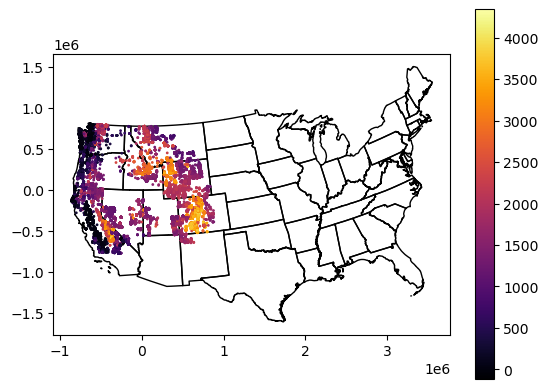

In [ ]:
f, ax = plt.subplots()
states_gdf_aea.plot(ax=ax, facecolor='none', edgecolor='k')
glas_gdf_aea.plot(ax=ax, column='glas_z', cmap='inferno', markersize=1, legend=True);

### Extract the MultiPolygon geometry object for Washington from your reprojected states GeoDataFrame
* Use the state 'NAME' value to isolate the approprate GeoDataFrame record for Washington
* Assign the `geometry` attribute for this record to a new variable called `wa_geom`
    * This is a little tricky
    * After a boolean filter to get the WA record, you will need to use something like `iloc[0]` to extract a GeoSeries, and then isolate the `geometry` attribute
        * `wa_geom = wa_gdf.iloc[0].geometry`
    * Use the python `type()` function to verify that your output type is `shapely.geometry.multipolygon.MultiPolygon`

In [ ]:
# This is a new GeoDataFrame with one entry
wa_gdf = states_gdf_aea[states_gdf_aea['NAME'] == 'Washington']
# This is the Geometry object for that one entry
wa_geom = wa_gdf.squeeze().geometry

### Find the geometric center of WA state
* See the `centroid` attribute
* You may have to `print()` this to see the coordinates

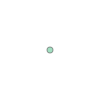

In [ ]:
#GeoDataFrame
#c = wa_gdf.centroid.iloc[0]
#MultiPolygon Geometry
c = wa_geom.centroid
c

## Part 1: Geometric Operations for GLAS points

### Clip the GLAS points to Washington state polygon
* This should be pretty straightforward:
    * Identify records from the GLAS GeoDataFrame that `intersects` the WA state geometry
    * Extract those records and store in a new GeoDataFrame
* This may take 5-10 seconds to complete

In [ ]:
#Student Exercise

### Compute some statistics for the WA state GLAS points
* How many points are in WA state?
* What is mean `glas_z` elevation in WA state?

In [ ]:
#Student Exercise

5265

In [ ]:
#Student Exercise

### Plot the resulting points
* Add the WA polygon outline
    * Note that you don't need/want to use the Polygon Geometry object here.  Remember, you have a GeoDataFrame containing just the WA geometry.  And you know how to plot GeoDataFrames.
* Add the WA state centroid you calculated earlier using a distinct marker style (e.g., `'*'` or `'x'`)
    * Can use simple matplotlib `plot` with the coordinates, or can use `wa_gdf.centroid.plot()`

In [ ]:
#Student Exercise

### Find the GLAS point closest to the WA state centroid
* See the GeoDataFrame `distance` function
* Create a plot showing this distance for each GLAS point.

In [ ]:
#Student Exercise

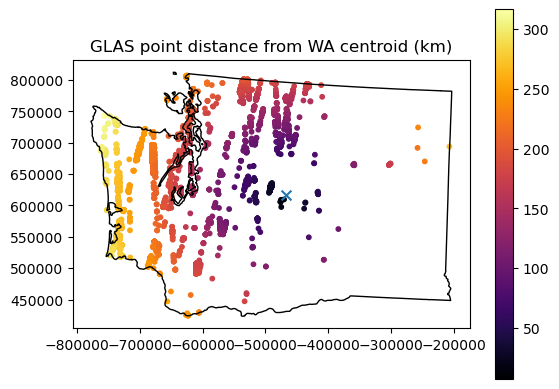

In [ ]:
#Student Exercise

### What is the distance between this point and the centroid in km?

In [ ]:
#Student Exercise

* Extra Credit: Do a quick calculation using the Pythagorean theorem to determine Euclidian distance between the centroid and this point - does this match the output of the `distance` function?

### What is the `glas_z` value of this point?
* For this, we need to isolate the original GeoDataFrame record corresponding to the minimum distance
* We talked about `argmin` or `argmax` for NumPy arrays. For a DataFrame, we want to use the `idxmin()` method on the column or DataSeries containing the distance values, which should give us the index value: 
    * https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
    * Can then use the index value to locate the corresponding record in the GeoDataFrame with standard Pandas indexing: https://pandas.pydata.org/docs/user_guide/indexing.html

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

1539.35

### Extra Credit: Which GLAS point is farthest from the WA state perimeter?
* Note that this is different than the above calcuations for point to point distance, you're looking for point to polyline distance
* What is the distance in km?
* This should be pretty straightforward, combining elements from the above questions/demo
* This can be useful to consider distance from the coast and climatology (temperature, precipitation and other environmental variables) 

In [ ]:
#Student Exercise

In [ ]:
#Student Exercise

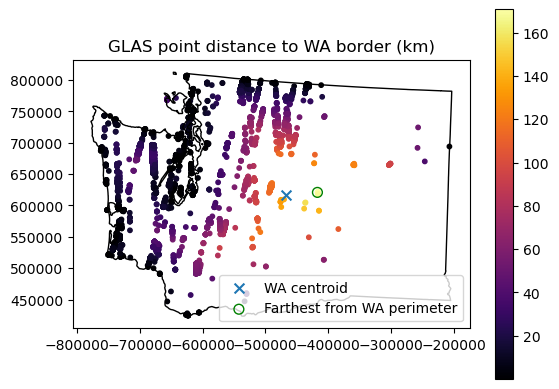

In [ ]:
#Student Exercise

## Part 2: Aggregate GLAS points for state polygons and compute `glas_z` statistics

OK, we computed some stats for GLAS points within WA state.  Now let's find the GLAS points that intersect **each** state polygon. 

Objectives:
1. Compute the total number of points and mean `glas_z` point elevation for each state
2. Generate choropleth maps for both

One approach would be to loop through each state polygon, and do an intersection operation like we did for WA state above.  But this is inefficient, and doesn't scale well.  It is much more efficient to do a spatial join between the points and the polygons with the intersection operator, then groupby and aggregate to compute the relevant statistics for each state.

You may have learned how to perform a join or spatial join in a GIS class.  So, do we need to open ArcMap or QGIS here?  Do we need a full-fledged spatial database like PostGIS?  No!  GeoPandas has you covered.

### Start with a spatial join between the GLAS points and state polygons
* Start by reviewing the Spatial Join documentation here: http://geopandas.org/mergingdata.html
* Use the geopandas `sjoin` method: http://geopandas.org/reference/geopandas.sjoin.html

### Let's extract the columns that matter
* Since we only care about `glas_z` values here let's create some smaller GeoDataFrames:
    * Extract the `['glas_z', 'geometry']` columns from the GLAS GeoDataFrame
    * Extract the `['NAME', 'geometry']` columns from the states GeoDataFrame

In [ ]:
glas_gdf_aea_lite = glas_gdf_aea[['glas_z', 'geometry']]
states_gdf_aea_lite = states_gdf_aea[['NAME','geometry']]

### Now try a spatial join between these two 
* Use the GLAS points as the "left" GeoDataFrame and the States as the "right" GeoDataFrame
* Start by using default options (`predicate='intersects', how='inner'`)
* Note the output geometry type and columns

In [ ]:
#Student Exercise

,glas_z,geometry,index_right,NAME
0,1398.51,POINT (709465.483 277418.898),50,Wyoming
1,1387.11,POINT (709431.326 276549.914),50,Wyoming
2,1392.83,POINT (709424.459 276376.270),50,Wyoming
3,1384.24,POINT (709417.614 276202.405),50,Wyoming
4,1369.21,POINT (709410.847 276028.547),50,Wyoming
...,...,...,...,...
64091,1868.30,POINT (485179.859 -614501.598),31,New Mexico
64499,1701.32,POINT (531778.415 -627890.213),31,New Mexico
64500,1735.44,POINT (531666.256 -629442.175),31,New Mexico
8377,1362.41,POINT (87991.625 -555886.651),2,Arizona


### Now reverse the order of the two input GeoDataFrames
* Use default options again

In [ ]:
#Student Exercise

### Which one makes more sense?
* Remember, we're trying to add a State name to each GLAS point
* You'll need to decide which one to use moving forward 

In [ ]:
#Student Exercise

### Extra credit
Experiment with a few different operations (`op`) for the spatial join (e.g., `intersects`) and review the output with `head()`
* Descriptions of different operations are here: https://shapely.readthedocs.io/en/stable/manual.html#object.intersects
    * Note that for our input spatial join of points and polygons, some of the details are irrelevant
* Do you notice a difference in the output number of records?
* Choose the `how` keyword appropriately:
    * Test a few options and note the output number of records
    * Are there any points that don't fall within a state polygon?  Why might this be?  Do you want to preserve these moving forward?

In [ ]:
#Student Exercise

### Sanity check
* Run a `head` on our new GeoDataFrame
* For each GLAS point, there should be a new column with the corresponding state NAME
* Check the original and joined `shape`
    * Does the number of records equal the original number of GLAS points?
    * Why might they be different?

#### Extra credit: plot the points that were not included in spatial join
* Does the spatial distribution help you answer the above question?
* Maybe useful to zoom in to look at points and state outlines

In [ ]:
#Student Exercise

,glas_z,geometry,index_right,NAME
0,1398.51,POINT (709465.483 277418.898),50,Wyoming
1,1387.11,POINT (709431.326 276549.914),50,Wyoming
2,1392.83,POINT (709424.459 276376.270),50,Wyoming
3,1384.24,POINT (709417.614 276202.405),50,Wyoming
4,1369.21,POINT (709410.847 276028.547),50,Wyoming


In [ ]:
#Student Exercise

Original count: 65236
Joined count: 63850


In [ ]:
#Student Exercise

#Student Exercise

### Now aggregate by state `NAME`
* Note: the GeoPandas doc example uses a `dissolve` operation here, which is a wrapper around the `groupby` and `agg` Pandas functions
    * https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
* But look at the geometry column for the points in your GeoDataFrame.  The `dissolve` is going to compute the union for the points in each state and return a `MultiPoint` Geometry for each state, which we don't really want/need.  It will also take longer to run.
* Instead, let's try a `groupby` operation for the `NAME` column, and then `agg` with a list of functions we care about: `['count', 'mean']` (statitiscs for point count and mean point elevation for each state)
    * We did this in Lab03!
    * https://uwgda-jupyterbook.readthedocs.io/en/latest/modules/03_NumPy_Pandas_Matplotlib/03_NumPy_Pandas_Demo.html#groupby

In [ ]:
#Student Exercise

/tmp/ipykernel_465/4031457243.py:2: FutureWarning: ['geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  glas_gdf_aea_states_agg = glas_gdf_aea_states.groupby('NAME').agg(['count', 'mean'])


glas_z              index_right      
            count         mean       count  mean
NAME                                            
Arizona         2  1355.220000           2   2.0
California  13865  1701.699116       13865   4.0
Colorado     8429  3253.791521        8429   5.0
Idaho        7297  1790.290550        7297  12.0
Montana      2658  2125.944759        2658  26.0
Nevada      12081  1335.431521       12081  28.0
New Mexico    209  1835.156699         209  31.0
Oregon       2838  1500.335525        2838  37.0
Utah         5498  1439.914989        5498  44.0
Washington   5265  1224.196596        5265  47.0
Wyoming      5708  2106.420340        5708  50.0

### Sanity check
* That groupby and agg should be pretty fast (~1-2 seconds)
* Check the `type()` of the output
* Since `groupby` and `agg` are Pandas operation, you should now have a new Pandas `DataFrame` (not a GeoPandas `GeoDataFrame`) with index of state names and columns for `count` and `mean` values in each state

In [ ]:
#Student Exercise

### Simplify the Heirarchical Index
* However, you may have noticed that you now have a "heirarchical index", with `count` and `mean` columns for both `glas_z` and `index_right`.
    * More info on this is here: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
    * This can be confusing at first, but is actually a powerful feature of Pandas.
    * For our situation, we don't care about `index_right` (byproduct of our spatial join), so you can simplify by extracting only the `glas_z` values
        * Do this the way you would extract a column from a standard DataFrame: `my_agg_df['glas_z']` and store as a new DataFrame
        * You can now directly access the `count` and `mean` columns

In [ ]:
#Student Exercise

## Part 3: Plots!
* How are we going to visualize these data?
* We have `count` and `mean` of GLAS points for each state!  Objective #1 complete!
* We now want to visualize these values, but we lost our state Polygon/MultiPolygon Geometry along the way
* No problem, we can combine our DataFrame with the original State GeoDataFrame
    * Can use `merge` to do an attribute join on the shared state `'NAME'` index for the two
        * Take a moment to review the `my_agg_df.merge?` options
        * In this case, we have a common `NAME` field, so we can use the `on='NAME'` here for attribute join
    * Careful about the order of the two inputs here (state GeoDataFrame and the DataFrame with your stats) - you want to preserve the index and geometry of the GeoDataFrame, adding the `count` and `mean` columns.
        * If you get it right, you should be able to `plot()` the GeoPandas GeoDataFrame and get a map.  If you got it backwards, the output of `plot()` will be a line plot for the regular Pandas DataFrame

In [ ]:
#Student Exercise

,NAME,geometry,count,mean
0,Arizona,"POLYGON ((154103.502 -554865.569, 154463.722 -...",2,1355.220000
1,California,"MULTIPOLYGON (((-715337.404 -425936.004, -7153...",13865,1701.699116
2,Colorado,"POLYGON ((676361.242 -79930.861, 687165.323 -7...",8429,3253.791521
3,Idaho,"POLYGON ((261921.702 118654.345, 261929.542 11...",7297,1790.290550
4,Montana,"POLYGON ((724628.849 373437.826, 721641.649 37...",2658,2125.944759
5,Nevada,"POLYGON ((19102.023 -111459.675, 19082.720 -13...",12081,1335.431521
6,New Mexico,"POLYGON ((788203.103 -1070451.319, 778535.190 ...",209,1835.156699
7,Oregon,"POLYGON ((-594594.782 433232.266, -593459.687 ...",2838,1500.335525
8,Utah,"POLYGON ((269119.721 -78373.504, 270165.794 -1...",5498,1439.914989
9,Washington,"MULTIPOLYGON (((-612752.940 729560.713, -61302...",5265,1224.196596


### Create a choropleth map to visualize the count of GLAS points in each state
* https://geopandas.readthedocs.io/en/latest/mapping.html#choropleth-maps

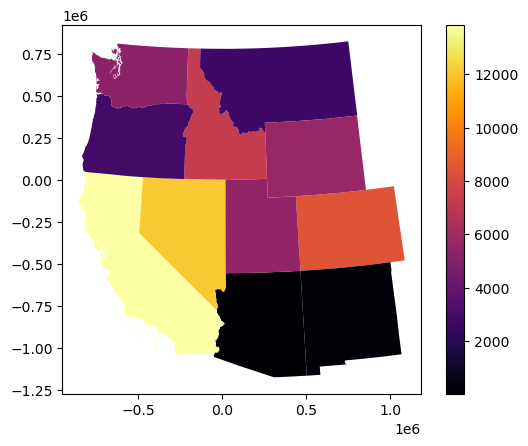

In [ ]:
#Student Exercise

### Create a choropleth map to visualize the mean elevation GLAS points in each state

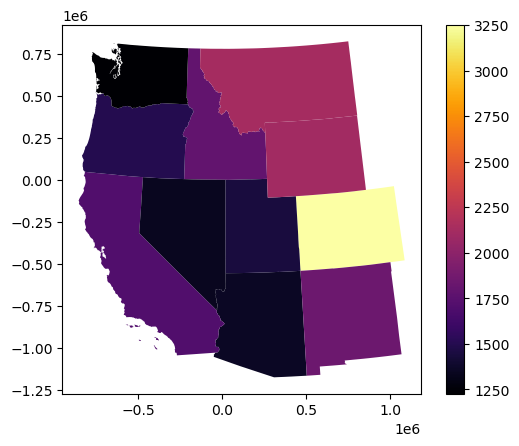

In [ ]:
#Student Exercise

## Part 4: Point Densitiy Visualization: Hexbin plots

OK, now we have statistics and plots for our existing polygons.  But what if we want to compute similar statistics for a regularly spaced grid of cells?  For our `count`, this will give us point density, allowing for better visualization of the spatial distribution.

We could define a set of adjacent rectangular polygons, and repeat our `sjoin`, `groupby`, `agg` sequence above.  Or we can use some existing matplotlib functionality, and create a hexbin plot!

Hexagonal cells are preferable over a standard square/rectangular grid for various reasons: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-whyhexagons.htm

Side note: Sarah Battersby (Tableau) had a nice paper exploring these issues for different projections: https://www.tandfonline.com/doi/full/10.1080/15230406.2016.1180263. "Shapes on a plane" is one of the better journal article titles I've ever seen :).

Here are some resources on generating hexbins using Python and matplotlib:
* https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hexbin.html
* http://darribas.org/gds15/content/labs/lab_09.html

*Note: an equal-area projection is always good idea for a hexbin plot.  Fortunately, we started with our AEA projection, so we're all set!*

### Create a hexbin that shows the number of points in each cell
* Play around with the `gridsize` option to set the number of bins in each dimension (or specify the dimensions of your bins)
* Use the `mincnt` option to avoid plotting cells with 0 count
* Overlay the state polygons to help visualize
* Set your plot `xlim` and `ylim` to the GLAS point bounds
* Can use linear color ramp with vmin and vmax options, or try a logarithmic color ramp, since we have a broad range of counts

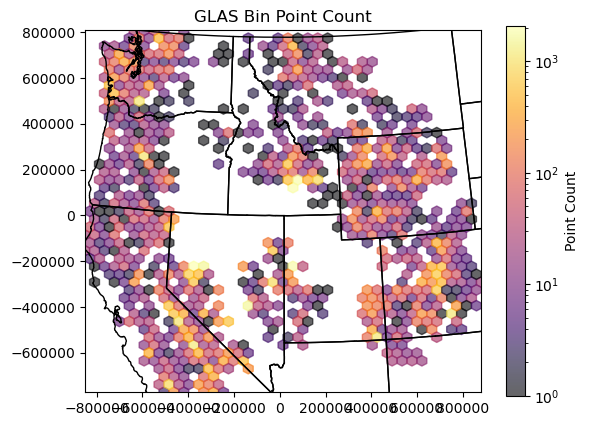

In [ ]:
#Student Exercise

### Create a second hexbin plot that shows the median elevation in each cell
* See documentation for the `C` and `reduce_C_function` options

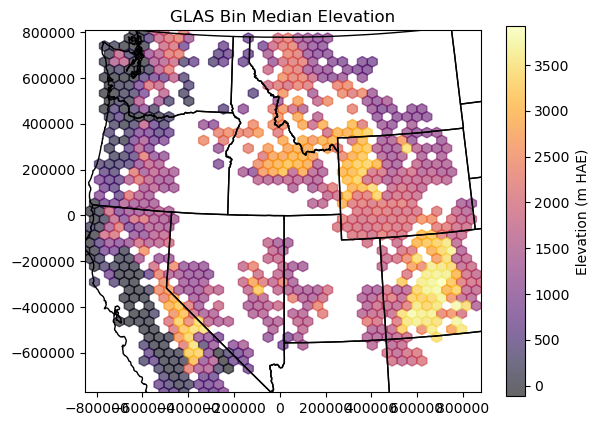

In [ ]:
#Student Exercise

### Extra Credit: Generate a Kernel Density Estimator (KDE) plot using `seaborn`
* This is another nice approach to estimate the point density on a continuous grid
* See motivation here for an explanation: https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation#Motivation
* Seaborn has a nice implementation for 2D data
    * https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
    * https://seaborn.pydata.org/tutorial/distributions.html

In [ ]:
glas_gdf_aea['glas_z'].values

array([1398.51, 1387.11, 1392.83, ..., 1556.19, 1556.18, 1556.32])

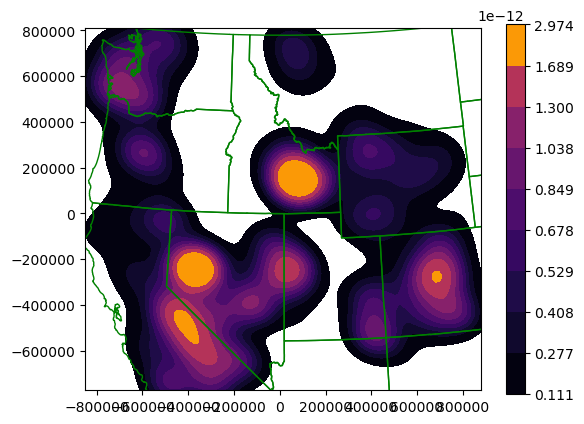

In [ ]:
#Student Exercise

### Static plots with tiled basemaps using `contextily`
* Our state outlines provide some context for our plots, but what if we want a raster map background
* Can use the convenientt `contextily` package for this: https://github.com/geopandas/contextily

In [ ]:
import contextily as ctx

In [ ]:
ctx.providers.Stamen.Terrain

{'url': 'https://stamen-tiles-{s}.a.ssl.fastly.net/{variant}/{z}/{x}/{y}{r}.{ext}',
 'html_attribution': 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
 'attribution': 'Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors',
 'subdomains': 'abcd',
 'min_zoom': 0,
 'max_zoom': 18,
 'variant': 'terrain',
 'ext': 'png',
 'name': 'Stamen.Terrain'}

### Using the default basemap projection
* Freely available tiled web maps are great: https://en.wikipedia.org/wiki/Tiled_web_map
* Most tiled basemaps use a standard "web mercator" projection (EPSG:3857)
* For this example, we will reproject our point GeoDataFrame to match the default tiles

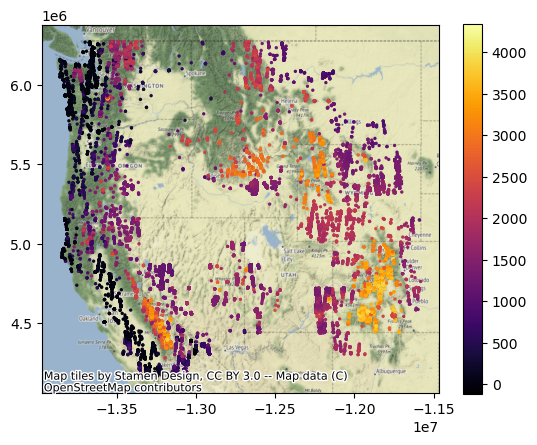

In [ ]:
f, ax = plt.subplots()
#Convert points to web mercator projection and plot
glas_gdf_aea.to_crs('EPSG:3857').plot(ax=ax, column='glas_z', cmap='inferno', markersize=2, legend=True)
#Add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.Terrain)

### Plot the WA points
* Explore different zoom levels
* Try at least one additional different ctx.provider
    * Maybe `ctx.providers.Esri.WorldImagery`

In [ ]:
#Student Exercise

### Using our custom projected coordinate system
* The contextily package also supports simple tile warping into arbitrary projections: https://contextily.readthedocs.io/en/latest/warping_guide.html
    * Note the `add_basemap` call is similar, just need to pass in the appropriate CRS object
* We will revisit raster reprojection during the Raster 2 lab, but for now try to plot using the Albers Equal-area projection
    * Note the curvature of the 49° parallel (border between US and Canada) compared to earlier plot in web mercator projection

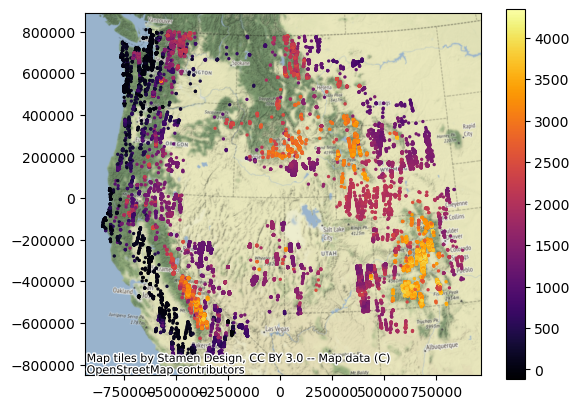

In [ ]:
f, ax = plt.subplots()
#Convert points to web mercator projection and plot
glas_gdf_aea.plot(ax=ax, column='glas_z', cmap='inferno', markersize=2, legend=True)
#Add basemap, specifying crs keyword
ctx.add_basemap(ax=ax, crs=glas_gdf_aea.crs, source=ctx.providers.Stamen.Terrain)

### Repeat for WA state

In [ ]:
#Student Exercise

## Part 5: Interactive plots
* See standalone notebook

## Extra Credit

### Create a function to identify the 3 closest points to each GLAS point 
* Then use these 3 points to:
    - Define a plane
    - Calculate the elevation on that planar surface at the original GLAS point coordinates
    - Compute the difference between the observed GLAS elevation and the interpolated elevation 
    
### For each GLAS point, compute mean and std for all points within a 10 km radius
* Can potentially create buffer around the point, then intersect with all points
* Can compute distance to all points, then threshold

### Load the Randolph Glacier Inventory polygons (see demo) and do a spatial join with state polygons
* Compute and plot the number of glaciers and total glacier area within each state.
* Which state has the highest number and area?